![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)

<table align="center">
  <td>
    <a href="https://colab.research.google.com/github/jpcano1/MINE_4210_Analisis_con_Deep_Learning/blob/master/lab_3/practica_6/practica_6_reg.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
  </td>
</table>

## **Práctica 6**

## **Aprendizaje por Transferencia - Regresión**

## **Objetivos**
- Introducción al uso de arquitecturas preentrenadas para el aprendizaje por transferencia.
- Usar TFRecord como método de carga eficiente de datos.
- Introducción a la localización de objetos mediante regresión.
- Callbacks personalizados.
- Optimización y tácticas de Boosting.
- Tensorflow functions y graph mode

## **Problema**
- En un dataset de aves, se busca localizar a cada una de ellas de manera simple, es decir, en cada imagen, habrá una única ave para localizar.



In [ ]:
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
import setup_colab_general as setup_general
setup_general.setup_general()

shred: setup_colab_general.py: failed to open for writing: No such file or directory


  0%|          | 0/3 [00:00<?, ?KB/s]

General Functions Enabled Successfully


In [ ]:
!pip install -q tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


## **Importando las librerías necesarias para el laboratorio**

In [ ]:
import numpy as np
import pandas as pd

import os

from google.colab import files

from tensorflow import keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split

from utils import general as gen
import cv2

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns

from typing import Optional, Any, List, Tuple

In [ ]:
train_id = "1shoNNn7PuTB-Hv46RV1Hv8E4W4umDWII"
val_id = "16MlEZxvNvuoek7IIDvs-JHxaKLE3OiZb"
test_id = "1E0A0Ve4vBEyOZAw9f0f5f__uAgyvQvsa"
weights_id = "1uxiEzsXN6-21cTN3DbOj8hhY0mcj7wPo"

In [ ]:
gen.download_file_from_google_drive(train_id, "train.tfrec")
gen.download_file_from_google_drive(val_id, "val.tfrec")
gen.download_file_from_google_drive(test_id, "test.tfrec")

0KB [00:00, ?KB/s]

0KB [00:00, ?KB/s]

0KB [00:00, ?KB/s]

## **Lectura, Visualización y Procesamiento**
- Como ya se vio en la práctica extra de TFRecord, es un tipo de archivo para leer datos de manera eficiente en el buffer de entrenamiento. En esta ocasión, utilizaremos el TFRecord generado en dicha práctica. 

In [ ]:
SHAPE = (224, 224)
BATCH_SIZE = 64
N_CLASSES = 200
TRAIN_SIZE = 7544
VAL_SIZE = 1886
TEST_SIZE = 2358

In [ ]:
train_ds = tf.data.TFRecordDataset(
    "data/train.tfrec", 
    num_parallel_reads=16
)
val_ds = tf.data.TFRecordDataset(
    "data/val.tfrec", 
    num_parallel_reads=16
)
test_ds = tf.data.TFRecordDataset(
    "data/test.tfrec", 
    num_parallel_reads=16
)

In [ ]:
@tf.function
def parse_image_function(
    example_input: tf.train.Example
) -> Optional[Tuple[tf.Tensor]]:
    """
    TF Function to parse a TFRecord 
    serialized single example
    :param example_input: The serialized TF 
    Example to be parsed
    :type example_input: Optional[tf.Tensor]
    :return: The resulting image, label 
    and bbox of the parsed Example
    :rtype: Optional[Tuple[tf.Tensor]]
    """
    # We extract the feature description from the example
    # represented by features of fixed length and fixed type
    image_feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "bbox": tf.io.FixedLenFeature([4], tf.int64),
    }

    # We parse example by example
    feature = tf.io.parse_single_example(
        example_input, image_feature_description
    )

    # We get the features from the feature dict
    image = feature["image"]
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.

    bbox = tf.cast(feature["bbox"], tf.float32)

    return image, bbox

@tf.function
def process_image(
    image: Optional[tf.Tensor], 
    bbox: Optional[tf.Tensor]
) -> Optional[Tuple[tf.Tensor]]:
    """
    Function to process the image, label and bbox
    :param image: The image to be processed
    :type image: Optional[tf.Tensor]
    :param bbox: The bbox of the image
    :type bbox: Optional[tf.Tensor]
    :return: The image and bbox processed
    :rtype: Optional[Tuple[tf.Tensor]]
    """
    shape = tf.shape(image)

    image = tf.image.resize(image, SHAPE)

    x_scale = SHAPE[1] / tf.cast(shape[1], tf.float32)
    y_scale = SHAPE[0] / tf.cast(shape[0], tf.float32)

    bbox = [
        tf.round(bbox[0] * x_scale),
        tf.round(bbox[1] * y_scale),
        tf.round(bbox[2] * x_scale),
        tf.round(bbox[3] * y_scale),
    ]

    return image, bbox

def performance(
    dataset: Optional[tf.data.Dataset], 
    train: bool = True
) -> Optional[tf.data.Dataset]:
    """
    Function to boost dataset load performance
    :param dataset: The dataset to be boosted
    :type dataset: Optional[tf.data.Dataset]
    :param train: Flag to indicate the nature of the dataset
    :type train: bool
    :return: The dataset boosted
    :rtype: Optional[tf.data.Dataset]
    """
    if train:
        # Shuffle the dataset to a fixed buffer sample
        dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
        # The number of batches that will be parallel processed
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
    # Repeat the incidences in the dataset
    dataset = dataset.repeat()
    # Create batches from dataset
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [ ]:
train_ds = train_ds.map(parse_image_function)
val_ds = val_ds.map(parse_image_function)
test_ds = test_ds.map(parse_image_function)

In [ ]:
train_ds = train_ds.map(process_image)
val_ds = val_ds.map(process_image)
test_ds = test_ds.map(process_image)

In [ ]:
for img, label in train_ds.take(5):
    tf.print("Image shape:", tf.shape(img))
    tf.print("Label:", label)

Image shape: [224 224 3]
Label: [111 46 85 147]
Image shape: [224 224 3]
Label: [43 29 159 191]
Image shape: [224 224 3]
Label: [23 37 159 126]
Image shape: [224 224 3]
Label: [46 44 137 160]
Image shape: [224 224 3]
Label: [106 36 75 90]


In [ ]:
imgs = []

for img, bbox in train_ds.take(9):
    new_img = cv2.rectangle(
        img.numpy(), 
        (bbox[0], bbox[1]), 
        (bbox[0] + bbox[2], bbox[1] + bbox[3]), 
        (1, 0, 0), 3
    )
    imgs.append(new_img)

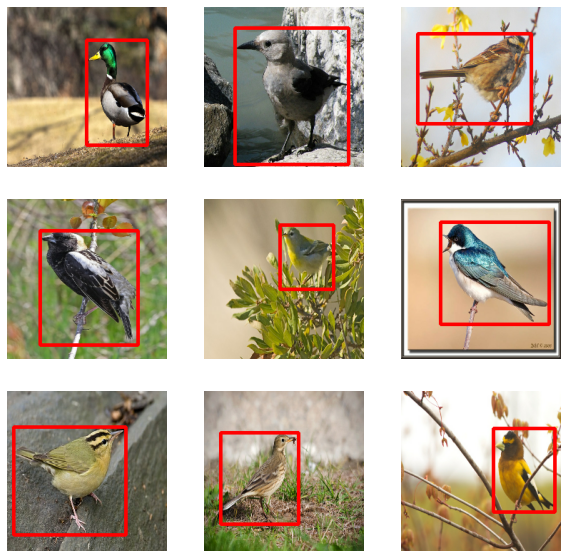

In [ ]:
gen.visualize_subplot(
    imgs, [""] * len(imgs),
    (3, 3), (10, 10),
)

In [ ]:
train_ds = performance(train_ds)
val_ds = performance(val_ds, False)
test_ds = performance(test_ds, False)

## **Modelamiento**
- Inception:

![image](https://cloud.google.com/tpu/docs/images/inceptionv3onc--oview.png?hl=es)

In [ ]:
base_model = keras.applications.InceptionV3(
    input_shape=(*SHAPE, 3),
    include_top=False,
    weights="imagenet",
)

global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dense_1 = keras.layers.Dense(128, activation="relu")(global_avg)
dense_2 = keras.layers.Dense(64, activation="relu")(dense_1)
dense_out = keras.layers.Dense(4)(dense_2)

model = keras.Model(inputs=base_model.input, outputs=dense_out)

lr = 1e-3
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    loss="mae",
    metrics=[tfa.metrics.RSquare(y_shape=(4, ), name="r2")]
)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
if not os.path.exists("models"):
    os.makedirs("models")

weights_dir = "models/weights.h5"

In [ ]:
gen.download_file_from_google_drive(weights_id, "weights.h5", dst="models")

0KB [00:00, ?KB/s]

In [ ]:
model.load_weights("models/weights.h5")

In [ ]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, weights_dir, patience=10, rate=0.5):
        """
        Initializer Method
        :param weights_dir: The directory of the model weights
        :param patience: Number of epochs before reducing lr
        :param rate: The rate to reduce the lr
        """
        super(CustomCallback, self).__init__()
        self.weights_dir = weights_dir
        self.rate = rate
        self.patience = patience

    def on_train_begin(self, logs=None):
        """
        Configurations to be taken an account on
        before training begins.
        :param logs: The logs from the output.
        :param type: dict
        """
        self.best_loss = np.Inf
        self.wait = 0
        self.best_weights = None
    
    def on_epoch_end(self, epoch, logs=None):
        """
        Method that is called each time an epoch ends
        excecution
        :param epoch: The current epoch of the training
        :para type: int
        :param logs: The logs from the output from an epoch ended
        :param type: dict
        """
        # Current validation loss
        current_loss = logs.get("val_loss")
        if current_loss < self.best_loss:
            # We save the model weights
            # We wait again
            # We assign the best loss and the best recall.
            self.wait = 0
            self.best_loss = current_loss
            self.model.save_weights(self.weights_dir)
            self.best_weights = self.model.get_weights()
            print("\nBest Weights Saved!!")
        else:
            self.wait += 1
            if self.wait >= self.patience:
                # Reduce learning rate by the initialized rate.
                self.wait = 0
                print(f"\nEpoch {epoch}, Reducing Learning Rate")
                # We set the new learning rate
                lr = K.get_value(self.model.optimizer.lr)
                new_lr = lr * self.rate
                K.set_value(self.model.optimizer.lr, new_lr)
                print(f"\nLearning Rate Reduced: {new_lr}")
                # We load the best weights to continue the training.
                self.model.set_weights(self.best_weights)
                print("\nBest Weights Loaded!!")

In [ ]:
train_params = {
    "steps_per_epoch": TRAIN_SIZE // BATCH_SIZE,
    "validation_steps": VAL_SIZE // BATCH_SIZE,
    "epochs": 50,
    "validation_data": val_ds,
    "callbacks": [CustomCallback(weights_dir, patience=3, rate=0.8)]
}

In [ ]:
model.fit(train_ds, **train_params)

In [ ]:
files.download("models/weights.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Validación y Predicción**

In [ ]:
test_loss, test_r2 = model.evaluate(test_ds, steps=TEST_SIZE // BATCH_SIZE)

36/36 [==============================] - 49s 462ms/step - loss: 4.6776 - r2: 0.9322


In [ ]:
imgs = np.zeros((BATCH_SIZE, *SHAPE, 3))
bboxes = np.zeros((BATCH_SIZE, 4))

for img_batch, bbox_batch in test_ds.take(1):
    for idx, (img, bbox) in enumerate(zip(img_batch, bbox_batch)):
        imgs[idx] = img.numpy()
        bboxes[idx] = bbox.numpy()

In [ ]:
bbox_predictions = model.predict(imgs)

In [ ]:
labeled_imgs = []

for idx, (img, bbox) in enumerate(zip(imgs[:9], bboxes[:9])):
    new_img = cv2.rectangle(
        img, 
        (int(bbox[0]), int(bbox[1])), 
        (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])), 
        (1, 0, 0), 3
    )
    new_img = cv2.rectangle(
        new_img,
        (
            int(bbox_predictions[idx][0]), 
            int(bbox_predictions[idx][1]),
        ),
        (
            int(
                bbox_predictions[idx][0] + bbox_predictions[idx][2]
            ), 
            int(
                bbox_predictions[idx][1] + bbox_predictions[idx][3]
            ),
        ),
        (0, 1, 0), 3
    )
    labeled_imgs.append(new_img)

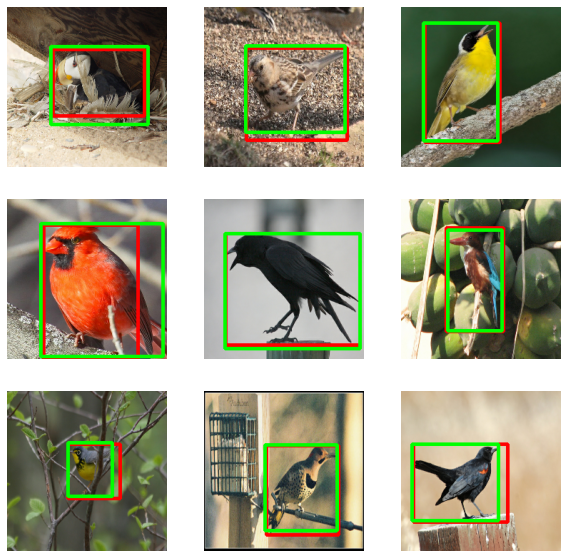

In [ ]:
gen.visualize_subplot(
    labeled_imgs, [""] * len(labeled_imgs),
    (3, 3), (10, 10)
)